# An end-to-end PDSCH Simulation with Trajectory-based Channel Model
This notebook shows how to create an end-to-end PDSCH communication and calculate the bit error rate while the user is moving on a trajectory.

In [1]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt

from neoradium import DeepMimoData, TrjChannel, Carrier, PDSCH, AntennaPanel, Grid, random


In [2]:
# Replace this with the folder on your computer where you store DeepMIMO scenarios
dataFolder = "/data/RayTracing/DeepMIMO/Scenarios/V4/"
DeepMimoData.setScenariosPath(dataFolder)

# Create a DeepMimoData object
deepMimoData = DeepMimoData("asu_campus_3p5")
deepMimoData.print()


DeepMimoData Properties:
  Scenario:                   asu_campus_3p5
  Version:                    4.0.0a3
  UE Grid:                    rx_grid
  Grid Size:                  411 x 321
  Base Station:               BS (at [166. 104.  22.])
  Total Grid Points:          131,931
  UE Spacing:                 [1. 1.]
  UE bounds (xyMin, xyMax)    [-225.55 -160.17], [184.45 159.83]
  UE Height:                  1.50
  Carrier Frequency:          3.5 GHz
  Num. paths (Min, Avg, Max): 0, 6.21, 10
  Num. total blockage:        46774
  LOS percentage:             19.71%




Trajectory Properties:
  start (x,y,z):         (-209.55, 69.83, 1.50)
  No. of points:         15333
  curIdx:                0 (0.00%)
  curSpeed:              [ 9.9 -9.9  0. ]
  Total distance:        107.30 meters
  Total time:            7.666 seconds
  Average Speed:         13.996 m/s
  Carrier Frequency:     3.5 GHz
  Paths (Min, Avg, Max): 6, 8.99, 10
  Totally blocked:       0
  LOS percentage:        29.09%



(<Figure size 742.518x471.734 with 1 Axes>,
 <Axes: title={'center': 'Map of LOS/NLOS paths'}, xlabel='X', ylabel='Y'>)

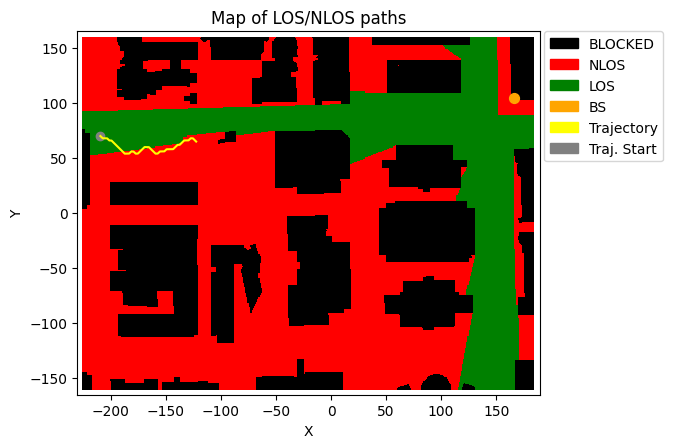

In [3]:
random.setSeed(123)                                 # Make results reproducible

# Create the carrier:
carrier = Carrier(startRb=0, numRbs=25, spacing=30) # Carrier with 25 Resource Blocks, 15KHz subcarrier spacing
bwp = carrier.curBwp                                # The only bandwidth part in the carrier

# Create a random trajectory at waking speed.
trajectory = deepMimoData.getRandomTrajectory(xyBounds=np.array([[-210, 40], [-120, 100]]),   # Traj. bounds
                                              segLen=2,               # Num grid points on shortest segment
                                              bwp=bwp,                # The bandwidth part
                                              trajLen=100,            # Number of grid points on trajectory
                                              speedMps=14,            # Speed in mps
                                              trajDir="+X")           # Trajectory direction

trajectory.print()                                  # Print the trajectory information
deepMimoData.drawMap("LOS-NLOS", trajectory)        # Draw the Map with the trajectory


Simulating end-to-end with "16QAM", and "Perfect" channel estimation, in time domain.
SNR(dB)   Total Bits   Bit Errors   BER(%)   Point    time(Sec.)
-------   ----------   ----------   ------   -----    ----------
    5      62400000     11082525     17.76    2000      170.12
   10      62400000      7576802     12.14    2000      171.35
   15      62400000      3814882      6.11    2000      169.40
   20      62400000       884722      1.42    2000      168.70
   25      62400000        27923      0.04    2000      168.67
   30      62400000           18      0.00    2000      167.88

Simulating end-to-end with "16QAM", and "LS" channel estimation, in time domain.
SNR(dB)   Total Bits   Bit Errors   BER(%)   Point    time(Sec.)
-------   ----------   ----------   ------   -----    ----------
    5      62400000     12443206     19.94    2000      172.28
   10      62400000      9061276     14.52    2000      172.68
   15      62400000      5317476      8.52    2000      171.76
   2

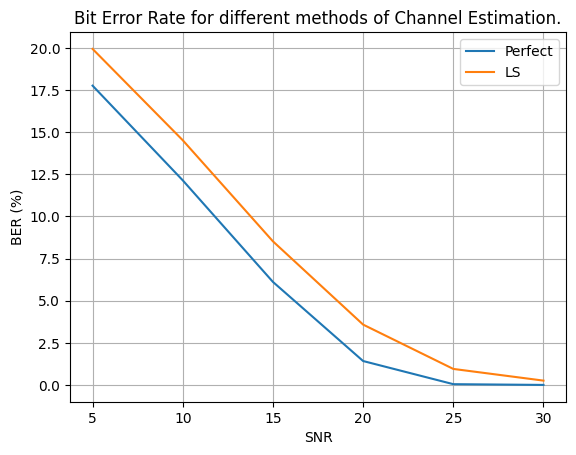

In [4]:
numFrames = 100                     # Number of time-domain frames (The first second on the trajectory)
snrDbs = [5,10,15,20,25,30]         # SNR values (in dB) for which we want to evaluate the model
freqDomain = False                  # Set to True to apply channel in frequency domain

modulation = "16QAM"                # Modulation Scheme

# Create a PDSCH object
pdsch = PDSCH(bwp, interleavingBundleSize=0, numLayers=2, nID=carrier.cellId, modulation=modulation)
pdsch.setDMRS(prgSize=0, configType=2, additionalPos=2)     # Specify the DMRS configuration

numSlots = bwp.slotsPerFrame*numFrames                      # Total number of slots
results = {}                                                # Dictionary to save the results

# Creating a trajectory-based channel model:
channel = TrjChannel(bwp, trajectory, 
                     txAntenna = AntennaPanel([2,4]),   # 8 TX antenna
                     txOrientation = [180,0,0],         # Make the BS antenna face to the left.
                     rxAntenna = AntennaPanel([1,2]),   # 2 RX antenna
                     seed = 123)  

minMse, maxMse = 100, 0
for chanEstMethod in ["Perfect", "LS"]:               # Two different channel estimation methods
    results[chanEstMethod] = {}
    print(f"\nSimulating end-to-end with \"{modulation}\", and \"{chanEstMethod}\" channel estimation, " +
          f"in {'frequency' if freqDomain else 'time'} domain.")
    print("SNR(dB)   Total Bits   Bit Errors   BER(%)   Point    time(Sec.)")
    print("-------   ----------   ----------   ------   -----    ----------")
    for snrDb in snrDbs:
        random.setSeed(123)                             # Making the results reproducible.
        t0 = time.time()
        channel.restart()

        bitErrors = 0
        totalBits = 0

        for slotNo in range(numSlots):
            grid = pdsch.getGrid()                      # Create a resource grid already populated with DMRS 
            numBits = pdsch.getBitSizes(grid)[0]        # Actual number of bits available in the resource grid
            txBits = random.bits(numBits)               # Create random binary data

            # Now populate the resource grid with coded data. This includes QAM modulation and resource mapping.
            pdsch.populateGrid(grid, txBits)

            # Store the indexes of the PDSCH data in pdschIndexes to be used later.
            pdschIndexes = pdsch.getReIndexes(grid, "PDSCH")   

            # Getting the Precoding Matrix, and precoding the resource grid
            channelMatrix = channel.getChannelMatrix()              # Get the channel matrix
            precoder = pdsch.getPrecodingMatrix(channelMatrix)      # Get the precoder matrix from PDSCH object
            precodedGrid = grid.precode(precoder)                   # Perform the precoding

            if freqDomain:
                rxGrid = precodedGrid.applyChannel(channelMatrix)   # Apply the channel in frequency domain
                rxGrid = rxGrid.addNoise(snrDb=snrDb)               # Add noise
            else:
                txWaveform = precodedGrid.ofdmModulate()            # OFDM Modulation
                maxDelay = channel.getMaxDelay()                    # Get the max. channel delay
                txWaveform = txWaveform.pad(maxDelay)               # Pad with zeros
                rxWaveform = channel.applyToSignal(txWaveform)      # Apply channel in time domain
                noisyRxWaveform = rxWaveform.addNoise(snrDb=snrDb, nFFT=bwp.nFFT)  # Add noise
                offset = channel.getTimingOffset()                  # Get timing info for synchronization
                syncedWaveform = noisyRxWaveform.sync(offset)       # Synchronization
                rxGrid = syncedWaveform.ofdmDemodulate(bwp)         # OFDM demodulation

            if chanEstMethod == "Perfect":                          # Perfect Channel Estimation
                estChannelMatrix = channelMatrix @ precoder[None,...]
            else:                                                   # LS + Interpolation Channel Estimation
                estChannelMatrix, noiseEst = rxGrid.estimateChannelLS(pdsch.dmrs, polarInt=False, 
                                                                      kernel='linear')
            act = channelMatrix @ precoder[None,...]
            mse1 = np.square(np.abs(estChannelMatrix - act)).mean()
            fEst = np.stack([estChannelMatrix.real, estChannelMatrix.imag], axis=4)
            fAct = np.stack([act.real, act.imag], axis=4)
            mse2 = np.square(fEst - fAct).mean()
            if minMse>mse2: minMse=mse2
            if maxMse<mse2: maxMse=mse2

            eqGrid, llrScales = rxGrid.equalize(estChannelMatrix)       # Equalization
            rxBits = pdsch.getHardBitsFromGrid(eqGrid, pdschIndexes)[0] # Demodulation
            bitErrors += np.abs(rxBits-txBits).sum()                    # Calculating number of bit errors
            totalBits += numBits
            print("\r  %3d      %8d     %8d    %6.2f  %6d      %6.2f"%(snrDb, totalBits, bitErrors, 
                                                                       bitErrors*100/totalBits, slotNo+1,
                                                                       time.time()-t0), end='')

            channel.goNext()                        # Prepare the channel model for the next slot

        dt = time.time()-t0                         # Total time for this SNR
        results[chanEstMethod][snrDb] = {"totalBits":totalBits, 
                                         "bitErrors":bitErrors, 
                                         "BER":      bitErrors*100/totalBits,
                                         "Time":     dt}
        print("\r  %3d      %8d     %8d    %6.2f  %6d      %6.2f"%(snrDb, totalBits, bitErrors, 
                                                            bitErrors*100/totalBits, slotNo+1, dt))

# Compare the results in a plot:
for i,chanEstMethod in enumerate(['Perfect', 'LS']):
    bers = [results[chanEstMethod][snrDb]["BER"] for snrDb in snrDbs]
    plt.plot(snrDbs, bers, label=chanEstMethod)
plt.legend()
plt.title("Bit Error Rate for different methods of Channel Estimation.");
plt.grid()
plt.xlabel("SNR")
plt.xticks(snrDbs)
plt.ylabel("BER (%)")
# plt.yscale('log')
plt.show()